Let us create synthetic data.
We consider 

In [1]:
import numpy as np
import torch

In [2]:
n = 500
# here we define 2 Gaussian latents variables z = (l_1, l_2)
l1 = np.random.normal(size=n)
l2 = np.random.normal(size=n)

latents = np.array([l1, l2]).T

# We define two random transformations from the latent space to the space of X and Y respectively
transform_x = np.random.randint(-8,8, size = 10).reshape([2,5])

# We compute data X = z w_x, and Y = z w_y
X = latents.dot(transform_x) 

# We we add some random Gaussian noise
X = X + 2*np.random.normal(size = n*5).reshape((n, 5))

X_normalized=(X-X.min())/(X.max()-X.min())
data=torch.Tensor([[[x]] for x in X_normalized])
data=1/(1+(-data).exp())

print('The latent space has dimension ' + str(latents.shape))
print('The transformation for X has dimension ' + str(transform_x.shape))

print('X has dimension ' + str(X.shape))
print('data has shape '+str(data.shape))

The latent space has dimension (500, 2)
The transformation for X has dimension (2, 5)
X has dimension (500, 5)
data has shape torch.Size([500, 1, 1, 5])


In [3]:
l1.mean(),l1.std()

(-0.045593664360977726, 1.1003703788011396)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [5]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc21 = nn.Linear(h_dim1, z_dim)
        self.fc22 = nn.Linear(h_dim1, z_dim)
        # decoder part
        self.fc3 = nn.Linear(z_dim, h_dim1)
        self.fc4 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 5))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var
    
    def get_z(self, x):
        mu, log_var = self.encoder(x.view(-1, 5))
        z = self.sampling(mu, log_var)
        return z
    

# build model
vae = VAE(x_dim=5, h_dim1= 10, z_dim=2)
    
vae

VAE(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (fc21): Linear(in_features=10, out_features=2, bias=True)
  (fc22): Linear(in_features=10, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=5, bias=True)
)

In [6]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1,5), reduction='sum')
    
    KLD = 0.5 * torch.sum(-1 - log_var +mu.pow(2) + log_var.exp())
    
    print(BCE.item(),KLD.item())
    return BCE + KLD



In [7]:
def train(epoch):
    vae.train()
        
    optimizer.zero_grad()

    recon_batch, mu, log_var = vae(data)
    loss = loss_function(recon_batch, data, mu, log_var)

    loss.backward()
    optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, loss.item()))

In [8]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [9]:
for epoch in range(1, 1001):
    train(epoch)

C:\Users\Yann\Anaconda3\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1754.0198974609375 60.9940185546875
====> Epoch: 1 Average loss: 1815.0139
1755.3133544921875 58.926116943359375
====> Epoch: 2 Average loss: 1814.2395
1753.0462646484375 56.91271209716797
====> Epoch: 3 Average loss: 1809.9590
1751.27294921875 54.953468322753906
====> Epoch: 4 Average loss: 1806.2264
1751.5870361328125 53.049434661865234
====> Epoch: 5 Average loss: 1804.6365
1747.320068359375 51.20131301879883
====> Epoch: 6 Average loss: 1798.5214
1751.5711669921875 49.40818405151367
====> Epoch: 7 Average loss: 1800.9794
1747.0982666015625 47.67253112792969
====> Epoch: 8 Average loss: 1794.7708
1748.5787353515625 45.99296569824219
====> Epoch: 9 Average loss: 1794.5717
1747.8702392578125 44.370574951171875
====> Epoch: 10 Average loss: 1792.2408
1744.3056640625 42.80460739135742
====> Epoch: 11 Average loss: 1787.1102
1743.309814453125 41.29454803466797
====> Epoch: 12 Average loss: 1784.6044
1742.42236328125 39.84004211425781
====> Epoch: 13 Average loss: 1782.2625
1741.460083007

1685.2752685546875 1.9866515398025513
====> Epoch: 108 Average loss: 1687.2620
1686.1634521484375 1.9159022569656372
====> Epoch: 109 Average loss: 1688.0793
1685.2237548828125 1.8470797538757324
====> Epoch: 110 Average loss: 1687.0708
1685.649658203125 1.7803893089294434
====> Epoch: 111 Average loss: 1687.4301
1686.029052734375 1.7158018350601196
====> Epoch: 112 Average loss: 1687.7449
1684.431640625 1.6533080339431763
====> Epoch: 113 Average loss: 1686.0850
1683.3153076171875 1.5925887823104858
====> Epoch: 114 Average loss: 1684.9078
1684.22412109375 1.5339152812957764
====> Epoch: 115 Average loss: 1685.7581
1683.72314453125 1.4773941040039062
====> Epoch: 116 Average loss: 1685.2006
1684.5953369140625 1.422879695892334
====> Epoch: 117 Average loss: 1686.0182
1684.2139892578125 1.3704164028167725
====> Epoch: 118 Average loss: 1685.5844
1682.9959716796875 1.3196253776550293
====> Epoch: 119 Average loss: 1684.3156
1681.97705078125 1.2708138227462769
====> Epoch: 120 Average lo

====> Epoch: 212 Average loss: 1665.1570
1665.1214599609375 0.15231263637542725
====> Epoch: 213 Average loss: 1665.2738
1664.28369140625 0.1518445611000061
====> Epoch: 214 Average loss: 1664.4355
1665.819091796875 0.15137362480163574
====> Epoch: 215 Average loss: 1665.9705
1664.3824462890625 0.15097588300704956
====> Epoch: 216 Average loss: 1664.5334
1664.6781005859375 0.15062350034713745
====> Epoch: 217 Average loss: 1664.8287
1665.27880859375 0.15032503008842468
====> Epoch: 218 Average loss: 1665.4291
1664.1964111328125 0.15012776851654053
====> Epoch: 219 Average loss: 1664.3466
1664.5067138671875 0.14999479055404663
====> Epoch: 220 Average loss: 1664.6567
1664.239990234375 0.14988186955451965
====> Epoch: 221 Average loss: 1664.3899
1663.6309814453125 0.14987272024154663
====> Epoch: 222 Average loss: 1663.7809
1664.7982177734375 0.149865984916687
====> Epoch: 223 Average loss: 1664.9481
1663.7716064453125 0.15007033944129944
====> Epoch: 224 Average loss: 1663.9216
1663.521

1658.623291015625 0.14313825964927673
====> Epoch: 316 Average loss: 1658.7665
1658.617431640625 0.14312469959259033
====> Epoch: 317 Average loss: 1658.7605
1658.512451171875 0.14308315515518188
====> Epoch: 318 Average loss: 1658.6555
1658.614013671875 0.14298775792121887
====> Epoch: 319 Average loss: 1658.7570
1658.4320068359375 0.14292389154434204
====> Epoch: 320 Average loss: 1658.5750
1658.4110107421875 0.14283603429794312
====> Epoch: 321 Average loss: 1658.5538
1658.552734375 0.14273765683174133
====> Epoch: 322 Average loss: 1658.6954
1658.357666015625 0.1426369845867157
====> Epoch: 323 Average loss: 1658.5002
1658.9853515625 0.142479807138443
====> Epoch: 324 Average loss: 1659.1278
1658.3743896484375 0.14234969019889832
====> Epoch: 325 Average loss: 1658.5167
1658.766357421875 0.14221534132957458
====> Epoch: 326 Average loss: 1658.9086
1658.6168212890625 0.14208009839057922
====> Epoch: 327 Average loss: 1658.7589
1658.0753173828125 0.14200982451438904
====> Epoch: 328 

====> Epoch: 419 Average loss: 1656.5176
1656.6339111328125 0.1310630440711975
====> Epoch: 420 Average loss: 1656.7650
1656.8095703125 0.13098996877670288
====> Epoch: 421 Average loss: 1656.9406
1656.7493896484375 0.13093039393424988
====> Epoch: 422 Average loss: 1656.8804
1656.678466796875 0.13088643550872803
====> Epoch: 423 Average loss: 1656.8093
1656.503173828125 0.13087031245231628
====> Epoch: 424 Average loss: 1656.6340
1656.6129150390625 0.13082796335220337
====> Epoch: 425 Average loss: 1656.7438
1656.78857421875 0.13075408339500427
====> Epoch: 426 Average loss: 1656.9193
1656.658203125 0.13065898418426514
====> Epoch: 427 Average loss: 1656.7888
1656.6683349609375 0.1305406391620636
====> Epoch: 428 Average loss: 1656.7988
1656.6585693359375 0.13043171167373657
====> Epoch: 429 Average loss: 1656.7889
1656.597900390625 0.13034269213676453
====> Epoch: 430 Average loss: 1656.7283
1656.685546875 0.1302551031112671
====> Epoch: 431 Average loss: 1656.8158
1656.5538330078125

1655.998291015625 0.12264344096183777
====> Epoch: 523 Average loss: 1656.1210
1655.8013916015625 0.12256133556365967
====> Epoch: 524 Average loss: 1655.9240
1655.8631591796875 0.1224779486656189
====> Epoch: 525 Average loss: 1655.9856
1655.972412109375 0.12239259481430054
====> Epoch: 526 Average loss: 1656.0948
1655.8912353515625 0.12230515480041504
====> Epoch: 527 Average loss: 1656.0135
1655.917236328125 0.12221905589103699
====> Epoch: 528 Average loss: 1656.0394
1655.8917236328125 0.12213465571403503
====> Epoch: 529 Average loss: 1656.0139
1655.921142578125 0.12205123901367188
====> Epoch: 530 Average loss: 1656.0432
1655.96826171875 0.12197005748748779
====> Epoch: 531 Average loss: 1656.0902
1656.037353515625 0.12188610434532166
====> Epoch: 532 Average loss: 1656.1592
1656.0086669921875 0.12181872129440308
====> Epoch: 533 Average loss: 1656.1305
1655.9581298828125 0.1217530369758606
====> Epoch: 534 Average loss: 1656.0798
1655.811767578125 0.1216920018196106
====> Epoch:

====> Epoch: 626 Average loss: 1655.7677
1655.6676025390625 0.11464887857437134
====> Epoch: 627 Average loss: 1655.7822
1655.83203125 0.11458659172058105
====> Epoch: 628 Average loss: 1655.9467
1655.7501220703125 0.11452630162239075
====> Epoch: 629 Average loss: 1655.8646
1655.5927734375 0.11446988582611084
====> Epoch: 630 Average loss: 1655.7073
1655.693359375 0.11438924074172974
====> Epoch: 631 Average loss: 1655.8077
1655.643798828125 0.11430805921554565
====> Epoch: 632 Average loss: 1655.7581
1655.76953125 0.11421218514442444
====> Epoch: 633 Average loss: 1655.8838
1655.591064453125 0.11412426829338074
====> Epoch: 634 Average loss: 1655.7052
1655.7435302734375 0.11403912305831909
====> Epoch: 635 Average loss: 1655.8575
1655.753662109375 0.11396759748458862
====> Epoch: 636 Average loss: 1655.8677
1655.800537109375 0.11390063166618347
====> Epoch: 637 Average loss: 1655.9144
1655.56005859375 0.11383163928985596
====> Epoch: 638 Average loss: 1655.6740
1655.7467041015625 0.1

====> Epoch: 730 Average loss: 1655.5844
1655.5697021484375 0.10679510235786438
====> Epoch: 731 Average loss: 1655.6765
1655.5020751953125 0.10670313239097595
====> Epoch: 732 Average loss: 1655.6088
1655.5194091796875 0.10660877823829651
====> Epoch: 733 Average loss: 1655.6260
1655.5126953125 0.10651597380638123
====> Epoch: 734 Average loss: 1655.6193
1655.4937744140625 0.10643056035041809
====> Epoch: 735 Average loss: 1655.6002
1655.6002197265625 0.10635089874267578
====> Epoch: 736 Average loss: 1655.7065
1655.6044921875 0.1062723696231842
====> Epoch: 737 Average loss: 1655.7108
1655.5025634765625 0.10620325803756714
====> Epoch: 738 Average loss: 1655.6088
1655.5618896484375 0.10613635182380676
====> Epoch: 739 Average loss: 1655.6680
1655.498779296875 0.10607099533081055
====> Epoch: 740 Average loss: 1655.6049
1655.49462890625 0.10600927472114563
====> Epoch: 741 Average loss: 1655.6006
1655.556640625 0.10594704747200012
====> Epoch: 742 Average loss: 1655.6626
1655.59521484

1655.4349365234375 0.09935906529426575
====> Epoch: 834 Average loss: 1655.5343
1655.43701171875 0.09928092360496521
====> Epoch: 835 Average loss: 1655.5363
1655.5108642578125 0.0992058515548706
====> Epoch: 836 Average loss: 1655.6101
1655.4842529296875 0.09913438558578491
====> Epoch: 837 Average loss: 1655.5834
1655.4703369140625 0.0990673303604126
====> Epoch: 838 Average loss: 1655.5695
1655.443115234375 0.09900543093681335
====> Epoch: 839 Average loss: 1655.5421
1655.4366455078125 0.09894061088562012
====> Epoch: 840 Average loss: 1655.5356
1655.45849609375 0.0988776683807373
====> Epoch: 841 Average loss: 1655.5574
1655.4029541015625 0.09880968928337097
====> Epoch: 842 Average loss: 1655.5017
1655.4947509765625 0.09874185919761658
====> Epoch: 843 Average loss: 1655.5935
1655.5283203125 0.0986732542514801
====> Epoch: 844 Average loss: 1655.6270
1655.419189453125 0.09860751032829285
====> Epoch: 845 Average loss: 1655.5178
1655.522705078125 0.09853443503379822
====> Epoch: 84

====> Epoch: 937 Average loss: 1655.4895
1655.4127197265625 0.09232479333877563
====> Epoch: 938 Average loss: 1655.5050
1655.4071044921875 0.09225741028785706
====> Epoch: 939 Average loss: 1655.4994
1655.3857421875 0.09219104051589966
====> Epoch: 940 Average loss: 1655.4779
1655.4608154296875 0.0921224057674408
====> Epoch: 941 Average loss: 1655.5530
1655.4088134765625 0.09205356240272522
====> Epoch: 942 Average loss: 1655.5009
1655.4434814453125 0.09198704361915588
====> Epoch: 943 Average loss: 1655.5355
1655.42529296875 0.0919274091720581
====> Epoch: 944 Average loss: 1655.5172
1655.3466796875 0.09186774492263794
====> Epoch: 945 Average loss: 1655.4386
1655.461669921875 0.09180670976638794
====> Epoch: 946 Average loss: 1655.5535
1655.390625 0.09174719452857971
====> Epoch: 947 Average loss: 1655.4824
1655.3865966796875 0.09168270230293274
====> Epoch: 948 Average loss: 1655.4783
1655.455078125 0.09160852432250977
====> Epoch: 949 Average loss: 1655.5466
1655.4678955078125 0.

In [10]:
prior_z=latents
prior_z

array([[ 4.41008540e-01,  1.75502286e-01],
       [-4.40103555e-01, -1.32570971e+00],
       [-1.72327227e+00, -5.73918953e-01],
       [-1.71766899e-01,  7.50864162e-01],
       [ 1.33067228e-01,  8.89221672e-01],
       [-7.09216611e-01, -3.26884457e-01],
       [-6.14116037e-01,  5.56552305e-01],
       [-5.25713333e-01,  8.21209391e-01],
       [-2.60288399e-01,  2.06464999e+00],
       [ 7.58491370e-01,  1.65050055e-02],
       [ 1.00642116e+00, -8.98539617e-01],
       [ 1.99381667e+00,  1.02778602e+00],
       [ 1.13734451e-01, -3.51895615e-01],
       [ 2.95794846e-01,  6.19884008e-01],
       [-6.60937829e-01, -7.83205499e-01],
       [ 2.26812308e-01,  3.84342117e-01],
       [-1.63298065e+00,  2.25589829e-01],
       [-1.71668633e+00,  2.17367634e-01],
       [-1.49573326e+00,  1.59112823e+00],
       [-1.99107860e+00, -6.98869715e-01],
       [ 8.41805658e-01, -1.32036892e+00],
       [-5.02886379e-01, -5.33818724e-01],
       [-2.20968068e+00,  1.06264492e+00],
       [-1.

In [11]:
q_z_x=vae.encoder(data)[0].view(-1,2).detach().numpy()
q_z_x

array([[-3.30422446e-03,  5.88222593e-03],
       [-1.08193345e-02, -8.83124769e-04],
       [ 7.48826191e-03, -1.60483271e-02],
       [ 6.00149855e-03,  4.55573201e-04],
       [ 2.28014961e-03,  2.73442268e-03],
       [ 4.70306724e-04, -3.74919176e-03],
       [ 5.16417995e-03, -4.54067439e-03],
       [ 1.42191164e-02, -4.17388231e-03],
       [ 2.52363198e-02, -5.14341891e-03],
       [-2.89158151e-03,  8.89734924e-03],
       [-1.76367499e-02,  1.35863423e-02],
       [-5.53980842e-03,  1.90062448e-02],
       [-1.03447773e-02,  3.62358987e-03],
       [ 7.22597912e-03, -1.50524080e-04],
       [-7.57195428e-03, -3.65459174e-03],
       [-1.35252997e-03,  2.91836262e-03],
       [ 1.16913877e-02, -1.47392750e-02],
       [ 1.19021721e-02, -1.40768960e-02],
       [ 2.81149112e-02, -1.66860595e-02],
       [ 8.30009207e-03, -1.66051909e-02],
       [-2.43660323e-02,  1.22306757e-02],
       [-6.82074577e-04, -4.78018075e-03],
       [ 2.65540592e-02, -2.12253630e-02],
       [ 9.

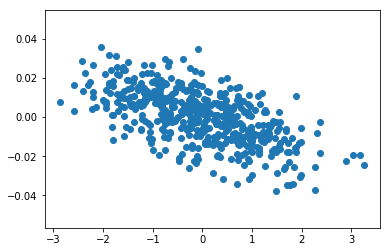

In [18]:
import matplotlib.pyplot as plt
plt.scatter(prior_z[:,0],q_z_x[:,0])

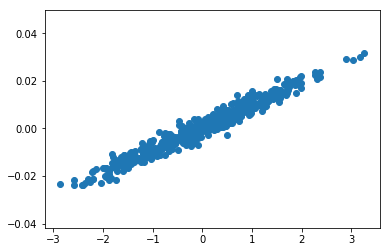

In [19]:
plt.scatter(prior_z[:,0],q_z_x[:,1])

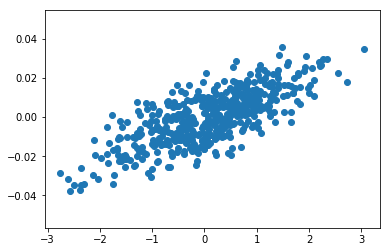

In [20]:
plt.scatter(prior_z[:,1],q_z_x[:,0])

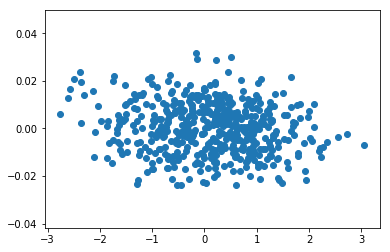

In [21]:
plt.scatter(prior_z[:,1],q_z_x[:,1])

In [22]:
z=vae.encoder(data)
z[0].mean()

tensor(0.0002, grad_fn=<MeanBackward0>)

In [17]:
latents.mean(),latents.std()

(0.02293197132662714, 1.0536953183644402)